<a href="https://colab.research.google.com/github/qazalmehrban/Medical-Segmentation/blob/ghazal/Unet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.transform import resize
import numpy as np
import nibabel as nib
import os 
import glob

import torch
import torch.nn as nn
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
samples = '/content/drive/MyDrive/samples/'
labels = '/content/drive/MyDrive/segmentation/'
mix = '/content/drive/MyDrive/New folder/'
#patients = next(os.walk(samples))[2]

#segmentations =next(os.walk(labels))[2]


In [27]:
#patients_object = os.scandir(samples)
#patients_list = [i.path for i in patients_object]
patients_list = glob.glob(mix + '*[0-9].*')
patients_list.sort()

#segment_object = os.scandir(labels)
#segment_list = [i.path for i in segment_object]
segment_list = glob.glob(mix + '*n.*')
segment_list.sort()










In [ ]:
def description(samples):
  unique_spational = set()
  all_spational_slice = []
  patients = os.listdir(samples)
  patients.sort()
  for number_file, image_id  in enumerate(patients):
    im = nib.load(os.path.join(samples, image_id))    
    im = np.array(im.dataobj)
    unique_spational.add(im.shape[:2])
    for slices in range(im.shape[2]):

      all_spational_slice.append(im.shape[:2])
  print(f"there are {len(unique_spational)} unique spational dimension")
  print(f"there are {number_file} patient image")
  for i in unique_spational:
   print(f'there are {all_spational_slice.count(i)} slice with shape {i}')


In [ ]:
description(samples)

In [ ]:
def description_mask(labels):
  segmentations = os.listdir(labels)
  segmentations.sort()

  k = set()
  num = []
  for i1 in segmentations:
    
    Masks = nib.load(os.path.join(labels, i1))    
    Masks = np.array(Masks.dataobj)
    for  j in range(Masks.shape[2]):
      u = np.unique(Masks[:,:,j])
      u = tuple(u.astype(np.int))
      k.add(u)
      num.append(u)
  for i in k :
    print(f'there are {num.count(i)} slice with label {i}')



In [ ]:
description_mask(labels)

In [28]:
def make_box(mask):
    box = []
    box_bool=[]
    obj_ids = np.unique(mask)
    if mask.dtype == bool:
        if len(np.unique(mask))==2:
            
            y_min = np.nonzero(mask)[0].min()
            y_max = np.nonzero(mask)[0].max()
            x_min = np.nonzero(mask)[1].min()
            x_max = np.nonzero(mask)[1].max()
            box=[x_min, y_min, x_max, y_max]
    else :
        mask_bool = mask.astype(np.bool)
        if len(np.unique(mask_bool))==2:
            
            y_min = np.nonzero(mask_bool)[0].min()
            y_max = np.nonzero(mask_bool)[0].max()
            x_min = np.nonzero(mask_bool)[1].min()
            x_max = np.nonzero(mask_bool)[1].max()
            box_bool=[x_min, y_min, x_max, y_max]
        
        for i in  obj_ids[1:]:
            y_min = np.nonzero(mask==i)[0].min()
            y_max = np.nonzero(mask==i)[0].max()
            x_min = np.nonzero(mask==i)[1].min()
            x_max = np.nonzero(mask==i)[1].max()
            box.append([x_min, y_min, x_max, y_max])
    return_object = box if mask.dtype ==bool else (dict(zip([f"label{int(i)}" for i in obj_ids[1:]],box)), box_bool)
    return return_object

In [39]:
Masks = nib.load(segment_list[56])   
Masks = np.array(Masks.dataobj)
print('shape', Masks.shape)
slices =13
Masks_2d = Masks[:,:,slices]
print(px.imshow(Masks_2d))

shape (384, 384, 20)
Figure({
    'data': [{'coloraxis': 'coloraxis',
              'type': 'heatmap',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}],
    'layout': {'coloraxis': {'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                            '#46039f'], [0.2222222222222222,
                                            '#7201a8'], [0.3333333333333333,
                                            '#9c179e'], [0.4444444444444444,
                                            '#bd3786'], [0.5555555555555556,
                                            '#d8576b'], [0.6666666666666666,
                                     

In [40]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
print(fig)
fig.add_trace(go.Bar(x=[1, 2, 3], y=[4, 5, 6],
                    marker=dict(color=[4, 5, 6], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=[1, 2, 3], y=[2, 3, 5],
                    marker=dict(color=[2, 3, 5], coloraxis="coloraxis")),
              1, 2)


print(fig)
fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.show()

Figure({
    'data': [],
    'layout': {'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 0.45]},
               'xaxis2': {'anchor': 'y2', 'domain': [0.55, 1.0]},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0]},
               'yaxis2': {'anchor': 'x2', 'domain': [0.0, 1.0], 'matches': 'y', 'showticklabels': False}}
})
Figure({
    'data': [{'marker': {'color': [4, 5, 6], 'coloraxis': 'coloraxis'},
              'type': 'bar',
              'x': [1, 2, 3],
              'xaxis': 'x',
              'y': [4, 5, 6],
              'yaxis': 'y'},
             {'marker': {'color': [2, 3, 5], 'coloraxis': 'coloraxis'},
              'type': 'bar',
              'x': [1, 2, 3],
              'xaxis': 'x2',
              'y': [2, 3, 5],
              'yaxis': 'y2'}],
    'layout': {'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 0.45]},
               'xaxis2': {'anchor': 'y2', 'domain': [0.55, 1.0]},
               'yaxis': {'a

In [42]:
fig['data'][0]

Bar({
    'marker': {'color': [4, 5, 6], 'coloraxis': 'coloraxis'}, 'x': [1, 2, 3], 'xaxis': 'x', 'y': [4, 5, 6], 'yaxis': 'y'
})

In [34]:
bounding_box_plot(Masks_2d)


labels_slice_13 [0. 2.]
bounding_box [117, 158, 181, 233]


In [ ]:
def bounding_box_plot(Masks_2d):
  
  print(f'labels_slice_{slices}', np.unique(Masks_2d))
  print('bounding_box', make_box(Masks_2d.astype(bool)))

  fig=px.imshow(Masks_2d)

  li = make_box(Masks_2d.astype(bool))

  k = dict(x0= li[0], x1= li[2], y0= li[1], y1= li[3])
  fig.add_shape(
    type='rect',
    **k,
    xref='x', yref='y',
    line_color='cyan'
  )
  fig.show()

In [43]:
def crop_specific(im, mask, crop_size):
        
        k=make_box(mask.astype(np.bool))
        if len(k)!=0:
            b_list = k
            x_min, y_min, x_max, y_max = b_list
            
            length_x = x_max -x_min + 1
            length_y = y_max - y_min + 1
            del_x = crop_size - length_x 
            del_y = crop_size - length_y 

            if del_x%2==0:
                kx = del_x//2
                sx=0
            else:
                kx = del_x//2

                sx = 1
            if del_y%2==0:
                ky = del_y//2
                sy=0
            else:
                ky = del_y//2
                sy = 1
            
            crop = mask[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1]
            crop_im = im[ y_min - ky - sy : y_max + ky + 1, x_min - kx - sx : x_max + kx  + 1]
            return crop_im, crop, 


In [45]:
crop_size = 192
p_seg = []
p_im = []
for patient_file, segment_file in zip( patients_list[:60], segment_list[:60]):
    im = nib.load(patient_file)    
    im = np.array(im.dataobj)

    Masks = nib.load(segment_file)    
    Masks = np.array(Masks.dataobj)
    Masks.shape
    for  j in range(Masks.shape[2]):
      k=make_box(Masks[:,:,j].astype(np.bool))
      if len(k)!=0:
        crop_im , crop = crop_specific(im[:,:,j], Masks[:,:,j], crop_size= crop_size)
        p_seg.append(crop)
        p_im.append(crop_im)


    
   

In [46]:
crop_size = 192
p_seg_t = []
p_im_t = []
for patient_file, segment_file in zip( patients_list[60:], segment_list[60:]):
    im = nib.load(patient_file)    
    im = np.array(im.dataobj)

    Masks = nib.load(segment_file)    
    Masks = np.array(Masks.dataobj)
    Masks.shape
    for  j in range(Masks.shape[2]):
      k=make_box(Masks[:,:,j].astype(np.bool))
      if len(k)!=0:
        crop_im , crop = crop_specific(im[:,:,j], Masks[:,:,j], crop_size= crop_size)
        p_seg_t.append(crop)
        p_im_t.append(crop_im)



In [47]:
segment_numpy = np.stack(p_seg,0)
image_numpy = np.stack(p_im, 0)

segment_numpy_t = np.stack(p_seg_t,0)
image_numpy_t = np.stack(p_im_t, 0)

In [49]:
segment_numpy_t.shape

(487, 192, 192)

In [50]:
train = image_numpy/image_numpy.max()
test = image_numpy_t/image_numpy.max()

In [51]:
train.dtype, segment_numpy.dtype

(dtype('float32'), dtype('float32'))

In [53]:
train_seg_bolean = segment_numpy.astype(bool)
test_seg_bolean = segment_numpy_t.astype(bool)

In [54]:
train_seg_bolean.dtype

dtype('bool')

In [57]:
test_seg_f = np.float32(test_seg_bolean)
train_seg_f = np.float32(train_seg_bolean)

In [58]:
test_seg_f.dtype

dtype('float32')

# Pytorch

In [ ]:
train_image_torch = np.expand_dims(train_image,1)
train_seg_torch  = np.expand_dims(train_seg_f,1)

In [ ]:
train_image_torch.shape

(556, 1, 192, 192)

In [ ]:
def conv1x1_bn_relu(inp_activation, output_activation, BN=True, activation = True):
    "con 1x1 + Batchnormalization + relu"
    layer = [nn.Conv2d(inp_activation, output_activation, 1)]
    for i, j in zip([nn.BatchNorm2d(output_activation), nn.ReLU(inplace=True)],[BN, activation]):
        if j==True:
            layer.append(i)
    return nn.Sequential(*layer)

In [ ]:
def conv3x3_bn_relu(inp_activation, output_activation, BN=True, activation = True):
    "con 3x3 + Batchnormalization + relu"
    layer = [nn.Conv2d(inp_activation, output_activation, 3, padding = 1)]
    for i, j in zip([nn.BatchNorm2d(output_activation), nn.ReLU(inplace=True)],[BN, activation]):
        if j==True:
            layer.append(i)
    return nn.Sequential(*layer)

In [ ]:
class bottleneck_block(nn.Module):
    
    def __init__(self, input_activation, list_filter=[256, 64, 256], down = None):
        super().__init__()
        self.conv1x1_1 = conv1x1_bn_relu(input_activation, list_filter[0])
        self.conv3x3 = conv3x3_bn_relu(list_filter[0], list_filter[1])
        self.conv1x1_2 = conv1x1_bn_relu(list_filter[1], list_filter[2])
        self.down = down
        if down!=None:
            self.contract_conv = down
    def forward(self , inp):
        x = inp
        c = self.conv1x1_1(inp)
        c = self.conv3x3(c)
        result = self.conv1x1_2(c)
        if self.down!=None:
            x = self.contract_conv(inp)
        
        out = result + x
        
        return out
            


In [ ]:
class conv_block(nn.Module):
    
    def __init__(self, inp_activation, list_filter ,resnet_block = False, downsample= None ):
        super().__init__()
        self.conv3x3_1 = conv3x3_bn_relu(inp_activation, list_filter)
        self.conv3x3_2 = conv3x3_bn_relu(list_filter, list_filter)
        self.down = downsample
    def forward(self , inp):
        c = self.conv3x3_1(inp)
        c = self.conv3x3_2(c)
        return c

In [ ]:
class Unet_res_b(nn.Module):
    def __init__(self, n_class):
        
        super().__init__()
        self.en_block1 = conv_block(1,32)
        self.en_block2 = conv_block(32,64)
        self.en_block3 = conv_block(64,128)
        self.en_block4 = conv_block(128,256)
        self.en_block5 = conv_block(256,512)
        self.en_block6 = conv_block(512, 1024)

        
        self.transpose5 = nn.ConvTranspose2d(1024,512,2,2)
        self.transpose4 = nn.ConvTranspose2d(512,256,2,2)

        self.transpose3 = nn.ConvTranspose2d(256,128,2,2)
        self.transpose2 = nn.ConvTranspose2d(128,64,2,2)
        self.transpose1 = nn.ConvTranspose2d(64,32,2,2)
        
        self.de_block1 = conv_block(64,32)
        self.de_block2 = conv_block(128,64)
        self.de_block3 = conv_block(256,128)

        self.de_block4 = conv_block(512, 256)
        self.de_block5 = conv_block(1024, 512)
        self.out_conv = nn.Conv2d(32, 1, 1)

        
    

    def forward(self, inp):
        el1 = self.en_block1(inp) #  (32,h,w)
        max1 = nn.MaxPool2d(2)(el1) # (32,h//2, w//2)

        el2 = self.en_block2(max1)    #(64, h//2, w//2)
        max2 = nn.MaxPool2d(2)(el2)  #(64, h//4, w//4)

        el3 = self.en_block3(max2)    #(128, h//4, w//4)
        max3 = nn.MaxPool2d(2)(el3)  #(128, h//8, w//8)

        el4 = self.en_block4(max3)    #(256, h//8, w//8)
        max4 = nn.MaxPool2d(2)(el4)  #(256, h//16, w//16)
        
        el5 = self.en_block5(max4)  #(512, h//16, w//16)
        max5 = nn.MaxPool2d(2)(el5)  #(512, h//32, w//32)
        
        el6 = self.en_block6(max5)  #(1024, h//32, w//32)

        el5 = self.transpose5(el6)  #(512, h//16, w//16)
        cat5 = torch.cat([el5, el5], 1) #(1024, h//16, h//16 )
        d5 =  self.de_block5(cat5)      #(512, h//16, w//16)
        
        tl4 = self.transpose4(d5)       #(256, h//8, w//8)
        cat4 = torch.cat([tl4, el4], 1) #(512, h//8, w//8)
        d4 =  self.de_block4(cat4)     #(256, h//8, w//8)
        
        tl3 = self.transpose3(d4)        #(128, h//4, w//4)
        cat3 = torch.cat([tl3, el3], 1)  #(256, h//4, w//4)
        d3 =  self.de_block3(cat3)        #(128, h//4, w//4)
        
        
        tl2 = self.transpose2(d3)          #(64, h//2, w//2)
        cat2 = torch.cat([tl2, el2], 1)   #(128, h//2, w//2)
        d2 =  self.de_block2(cat2)         #(64, h//2, w//2)
        
        tl1 = self.transpose1(d2)          #(32, h, w)
        cat1 = torch.cat([tl1, el1], 1) #(64, h, w)
        d1 =  self.de_block1(cat1)        #(32, h, w)
        output = self.out_conv(d1) 

        return output



In [ ]:
m = Unet_res_b(2)

In [ ]:
m.to(torch.device('cuda'))

Unet_res_b(
  (en_block1): conv_block(
    (conv3x3_1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3x3_2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (en_block2): conv_block(
    (conv3x3_1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3x3_2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

In [ ]:
m(torch.tensor(train_image_torch)[:3]).shape

torch.Size([3, 2, 192, 192])

In [ ]:
d_tr = torch.utils.data.DataLoader(train_image_torch,32)
d_seg = torch.utils.data.DataLoader(train_seg_torch,32)

In [ ]:
device = torch.device('cuda')

In [ ]:
opt = torch.optim.Adam(m.parameters())

In [ ]:
loss = torch.nn.BCELoss()

In [ ]:
im = im.to(device=device)


RuntimeError: ignored

In [ ]:
for im , segi in zip(d_tr, d_seg):
  im = im.to(device=device)
  segi =segi.to(device)
  yh = m(im)
  l = loss(yh, segi)
  #print(l)
  opt.zero_grad()
  l.backward()
  opt.step
  

RuntimeError: ignored

##tensorflow

In [60]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS  =crop_size, crop_size, 1

In [84]:
def U_Net_Segmentation(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    
    inputs = tf.keras.Input(input_size)
    
    
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)


    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)


    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)


    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)


    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c5)



    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c6)   


    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7) 

    u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c8) 
    
    
    u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis = 3)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c9) 
    
    outputs = layers.Conv2D(2,(1,1), activation="softmax",)(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [83]:
def Dice(y_true, y_pred):

    
    
  mask1 = tf.math.argmax(y_pred, axis=-1)

  y_pred= tf.cast(mask1, tf.float32)
  inter = tf.reduce_sum(y_pred * y_true, [1,2])
  uni = tf.reduce_sum(y_pred , [1,2])+ tf.reduce_sum( y_true, [1,2])

  des = tf.reduce_mean(2*inter/uni)
       
  return des



In [ ]:
model = U_Net_Segmentation()

In [75]:
optimizer = tf.keras.optimizers.Adam()


In [76]:
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[Dice])
                 

In [77]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return 0.01



In [66]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [78]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [79]:
results = model.fit(train, train_seg_f,
                    shuffle = True,
              validation_split = 0.1,
                    batch_size=32,
                    epochs=70, callbacks=[callback])

Epoch 1/70
24/24 [==============================] - 6s 175ms/step - loss: 0.6007 - Dice: 0.0316 - val_loss: 0.4353 - val_Dice: 0.0000e+00
Epoch 2/70
24/24 [==============================] - 4s 162ms/step - loss: 0.3887 - Dice: 0.0000e+00 - val_loss: 0.3447 - val_Dice: 0.0000e+00
Epoch 3/70
24/24 [==============================] - 4s 162ms/step - loss: 0.3227 - Dice: 4.8803e-05 - val_loss: 0.2635 - val_Dice: 0.0000e+00
Epoch 4/70
24/24 [==============================] - 4s 159ms/step - loss: 1.8765 - Dice: 0.0153 - val_loss: 0.4959 - val_Dice: 0.0000e+00
Epoch 5/70
24/24 [==============================] - 4s 156ms/step - loss: 0.4284 - Dice: 0.0000e+00 - val_loss: 0.4293 - val_Dice: 0.0000e+00
Epoch 6/70
24/24 [==============================] - 4s 156ms/step - loss: 0.3861 - Dice: 0.0000e+00 - val_loss: 0.4323 - val_Dice: 0.0000e+00
Epoch 7/70
24/24 [==============================] - 4s 156ms/step - loss: 0.3824 - Dice: 0.0000e+00 - val_loss: 0.4273 - val_Dice: 0.0000e+00
Epoch 8/70
24/

KeyboardInterrupt: ignored

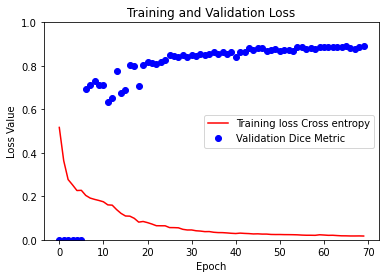

In [ ]:
loss = results.history['loss']
val_loss = results.history['val_Dice']

epochs = range(70)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss Cross entropy')
plt.plot(epochs, val_loss, 'bo', label='Validation Dice Metric')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

pr = model.predict(test_image[:7])

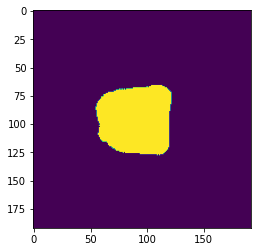

In [ ]:
mask1 = np.argmax(pr[2], axis=-1)
plt.imshow(mask1)


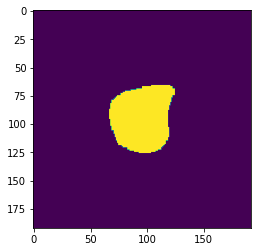

In [ ]:
plt.imshow(test_seg_f[2])
